In [1]:
import sys
sys.path.append('../src/')
import os
import copy

import numpy as np
import sklearn
from sklearn import metrics
import tensorly as tn
import math
import matlab.engine
import matplotlib.pyplot as plt
import time


import ll1_tools

## Load data and loewnerize


In [2]:
targets_path = '../data/Lenet300/activations/test/targets.npy'
targets = np.load(targets_path)
print(f"Targets shape: {targets.shape}")

inputs_path = '../data/Lenet300/activations/test/99/layers.layer_0.linear.npy'
inputs_raw = np.load(inputs_path)
print(f"Inputs shape: {inputs_raw.shape}")

outputs_path = '../data/Lenet300/activations/test/99/layers.layer_0.rat.npy'
outputs_raw = np.load(outputs_path)
print(f"Outputs shape: {outputs_raw.shape}")

# tensorlab_path = '~/ware/matlab_tools/tensorlab'
tensorlab_path = '~/tools/matlab_tools/Tensorlab'

num_sets = 10
tic = time.perf_counter()
lwn_tns_raw, obs, obs_trgts = ll1_tools.split_data(inputs_raw, outputs_raw, targets, tensorlab_path, num_sets)
toc = time.perf_counter()
print(toc-tic)

Targets shape: (9984,)
Inputs shape: (39, 256, 300)
Outputs shape: (39, 256, 300)
522.4310065789999


## remove inf values from lwn_tns: 
Rationale: if numerator of the lowner matrix entry is zero, so would be the numerator, hence replacing inf with zero is justified

In [3]:
lwn_tns = lwn_tns_raw
for t in lwn_tns:
    t[np.isinf(t)] = 0

## perform decompositions for all lwn_tns

In [14]:
eng = matlab.engine.start_matlab()
s = eng.genpath(tensorlab_path)
eng.addpath(s, nargout=0)

num_terms = 475
rat_deg = 3

L = rat_deg * np.ones(num_terms)
mdls = list()
outs = list()

tic = time.perf_counter()
for tns in lwn_tns:
    U, out = eng.ll1(tns, L, nargout=2)
    mdls.append(U)
    outs.append(out)
toc = time.perf_counter()
print(toc-tic)

16208.936800755007


## check model fits

[0.7427361295714587, 0.7464175854819838, 0.7424437886434057, 0.7406248396548747, 0.746931357260552, 0.746370584262858, 0.7391992991091054, 0.7586328865463852, 0.7561454551596947, 0.7363070851914908]


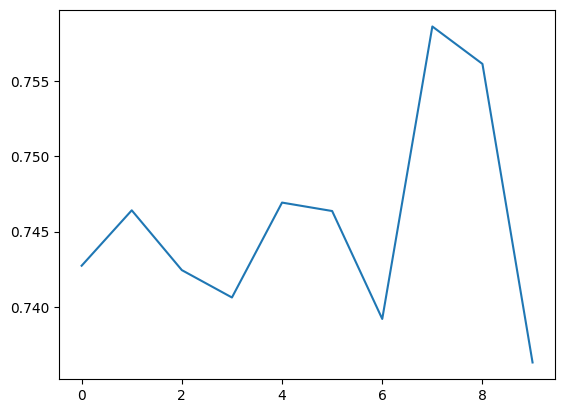

In [9]:
fits = []
for idx, mdl in enumerate(mdls):
    tmp_fit = 1 - eng.frobll1res(lwn_tns[idx], mdl) / eng.frob(lwn_tns[idx])
    fits.append(tmp_fit)
print(fits)
plt.plot(fits)

## Recover 'Sources' & 'Mixing' matrices for each set

In [10]:
print(f"Number of models: {len(mdls)}")
sources = list()
mixes = list()
for idx, model in enumerate(mdls):
    tmp = ll1_tools.pack_ll1(model)
    mix = tmp[2]
    mixes.append(mix)
    src = ll1_tools.recover_sources(obs[idx], mix)
    sources.append(src)
print(f"Number of Source matrices: {len(sources)}")
print(f"Number of Mixing matrices: {len(mixes)}")

Number of models: 10
Number of Source matrices: 10
Number of Mixing matrices: 10


## Perform SVDs on transposed 'Sources' matrices as well as maximum angle between subspaces
(transpose so the left singular vectors correspond to the sources signal space)

In [11]:
sources_transposed = []
for src in sources:
    sources_transposed.append(src.T)
print(len(sources_transposed))

svds = []
for src in sources_transposed:
    svds.append(np.linalg.svd(src))
num_sets = len(sources)

angles_srcs = np.zeros((num_sets,num_sets))
angles_cols = np.zeros((num_sets,num_sets))
norm_of_diffs = np.zeros((num_sets,num_sets))
# cossims = np.zeros((num_sets,num_sets))
for i in range(num_sets):
    for j in range(num_sets):
        if i != j:
            angles_srcs[i,j] = eng.rad2deg(eng.subspace(sources_transposed[i], sources_transposed[j]))
            angles_cols[i,j] = eng.rad2deg(eng.subspace(svds[i][0], svds[j][0]))
            norm_of_diffs[i,j] = np.linalg.norm(sources_transposed[i] - sources_transposed[j])
            # cossims[i,j] = sklearn.metrics.pairwise.cosine_similarity(sources_transposed[i], sources_transposed[j])

10


## SVD analysis

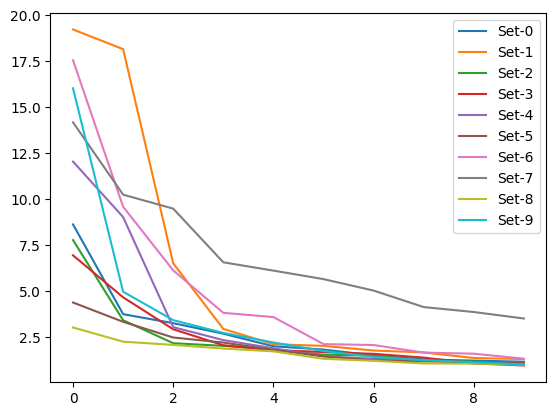

In [12]:
for i in range(len(svds)):
    plt.plot(svds[i][1][0:10], label=f"Set-{i}")

plt.legend()

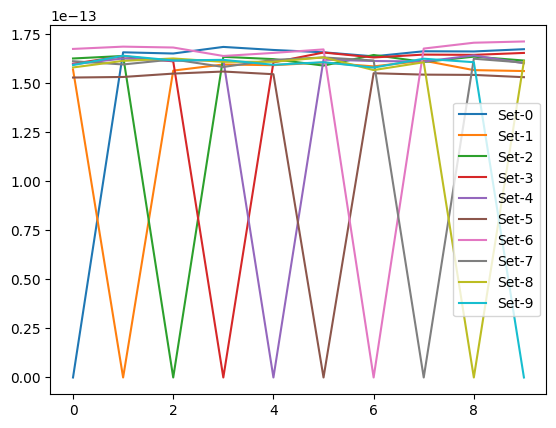

In [13]:
for i in range(angles_cols.shape[0]):
    plt.plot(angles_cols[i,:], label=f"Set-{i}")
plt.legend()

## Norm of diff analysis

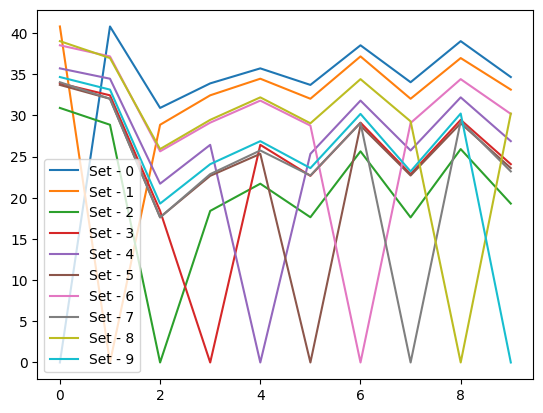

In [15]:
for i in range(norm_of_diffs.shape[0]):
    plt.plot(norm_of_diffs[i,:], label=f"Set - {i}")

plt.legend()

# Troubleshooting set indices 3,4,5,6

In [31]:
# lets look at 3
tmp_lwn_tns = lwn_tns[3]
tmp_mdl = mdls[3]
print(tmp_lwn_tns.shape)
print(tmp_lwn_tns[:3,:3,0])

# print(eng.frobll1res(tmp_lwn_tns, tmp_mdl, 'Format', 'true', nargout=1))
print(eng.frob(tmp_lwn_tns, nargout=1))
for i in range(3,7):
    contains_inf = np.isinf(lwn_tns[i]).any()
    print(contains_inf)


(150, 150, 998)
[[30.75259781 22.04794693  1.5287683 ]
 [ 9.87717342  5.95116854 -0.97770214]
 [14.490201    9.31506252 -0.76437545]]
inf
True
True
True
True


In [9]:
lwn_tns_adj = lwn_tns
for t in lwn_tns_adj:
    t[np.isinf(t)] = 0

for i in range(3,7):
    contains_inf = np.isinf(lwn_tns_adj[i]).any()
    print(contains_inf)

contains_zeros = np.any(inputs_raw==0)
print(contains_zeros)

False
False
False
False
False


In [34]:
mdls_adj = list()
outs_adj = list()

tic = time.perf_counter()
for tns in lwn_tns_adj:
    U, out = eng.ll1(tns, L, nargout=2)
    mdls_adj.append(U)
    outs_adj.append(out)
toc = time.perf_counter()
print(toc-tic)

the MATLAB function has been cancelled


Operation terminated by user during ll1_core/JHJx


In nls_gndl/JHJx (line 243)
    y = dF.JHJx(z,x);

In mpcg (line 78)
    else Ad = A(d); end

In nls_gndl (line 376)
                mpcg(@JHJx,-grad,options.CGTol,options.CGMaxIter,dF.PC, ...

In ll1_core (line 193)
    [U,output] = options.Algorithm(@objfun,dF,U0(:).',options);

In ll1_nls (line 40)
        [U, output] = ll1_core(T,U0,'Algorithm',@nls_gndl,'OptimizationType', ...

In ll1 (line 667)
    [U,output.Refinement] = options.Refinement(Tunc,UA0, ...



TypeError: cannot unpack non-iterable NoneType object